This post was originally going to focus on using multivariate linear regression to model hourly, regional electricity load data until I noticed that some of the series that I was importing from EIA appeared to be contaminated with outliers and missing data. I started to spend a considerable amount of time scrubbing the data and decided to just turn the scrubbing exercise into its own post. Data scrubbing is not always the most rewarding task but I tried to put an interesting spin on this by playing around with an unsupervised machine learning technique that can be used for outlier detection. The goal is to come up with a method that would dynamically identify outliers on the fly.

In [3]:
import sys
sys.path.insert(0, '/home/johnr_000/jupyter_blog/jupyter_blog/scripts')
import eia_model as em
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#variables to specify date range and frequency
api_key = '5F4109570C68FDE20F42C25F5152D879'
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
freq = 'H'
# create list of series used for dictionary keys
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']
# create dict of GetSeriesRange objects from series list
series_dict = {key: em.GetSeries(api_key=api_key, series_id=key, 
                                   start=start, end=end, freq=freq) for key in keys}

KeyboardInterrupt: 

In [50]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

NameError: name 'series_dict' is not defined

In [ ]:
# all the dataframes have the same date range so we can concatenate in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1)
# and output as a pickle file - I'm doing this to avoid calling the EIA API as I develop
# concat_df.to_pickle('data/nw_load_df.pkl')
# concat_df = pd.read_pickle('data/new_load_df.pkl')

In [4]:
concat_df = pd.read_pickle('/home/johnr_000/jupyter_blog/jupyter_blog/data/nw_load_df.pkl')

In [5]:
# print out descriptive statistics for each series
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7059.477471418964 ' median :'7109.0 ' min :'5006 ' max :'9365
EBA.PACE-ALL.D.H '	
 mean :'-24706.174848688635 ' median :'5508.0 ' min :'-31990166 ' max :'59668
EBA.PACW-ALL.D.H '	
 mean :'4451.197713517148 ' median :'2709.0 ' min :'-6785 ' max :'2530003
EBA.PGE-ALL.D.H '	
 mean :'2579.9219905850705 ' median :'2646.0 ' min :'1730 ' max :'3472
EBA.PSEI-ALL.D.H '	
 mean :'3946.0661268556005 ' median :'4021.0 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1282.2589105581708 ' median :'1324.0 ' min :'868 ' max :'1654


In [6]:
# first pass filter out negatives and zeroes
for key in keys:
    concat_df[concat_df[key] < 0] = np.nan

for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7057.380823767725 ' median :'7107.0 ' min :'5006.0 ' max :'9365.0
EBA.PACE-ALL.D.H '	
 mean :'5532.663065496286 ' median :'5508.0 ' min :'4108.0 ' max :'59668.0
EBA.PACW-ALL.D.H '	
 mean :'4478.549628629305 ' median :'2710.0 ' min :'1763.0 ' max :'2530003.0
EBA.PGE-ALL.D.H '	
 mean :'2578.5563808237675 ' median :'2643.0 ' min :'1730.0 ' max :'3472.0
EBA.PSEI-ALL.D.H '	
 mean :'3944.419376693767 ' median :'4017.5 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1281.6914247130317 ' median :'1322.0 ' min :'868.0 ' max :'1654.0


In [36]:
class PredictOutliers(object):
    
    def __init__(self, input_data, label, col1, col2, cont):
        self.training_data = pd.DataFrame(input_data.loc[:,[col1, col2]])
        self.label = label
        self.index = input_data.index.values
        self.clf = self.fit_clf(cont)
        self.pred_data = pd.concat([self.training_data, self.create_predictions()], axis=1)

    def fit_clf(self, cont):
        clf = IsolationForest(contamination=cont)
        return clf.fit(self.training_data.values)
        
    def create_predictions(self):
        opred = self.clf.predict(self.training_data.values)
        dfunc = self.clf.decision_function(self.training_data.values)
        l1 = '{}{}'.format(self.label, '_opred')
        l2 = '{}{}'.format(self.label, '_dfunc')
        return pd.DataFrame(np.column_stack((opred, dfunc)), index=self.index, columns=[l1, l2])

In [49]:
concat_df = concat_df.interpolate(method='linear')
concat_df.loc[:,'HOUR'] = pd.to_datetime(concat_df.index).hour
pred_dict = {key: PredictOutliers(concat_df, key, 'HOUR', key, .01) for key in keys}

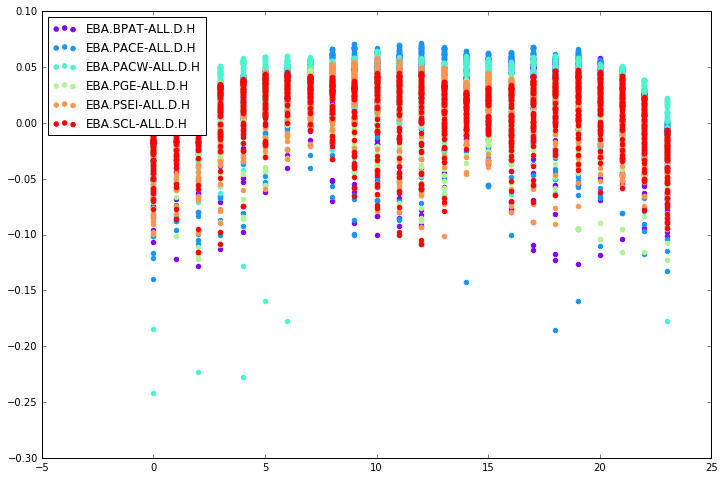

In [50]:
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
for key, color in zip(keys, colors):
    pred_data = pred_dict[key].pred_data
    plt.scatter(pred_data['HOUR'].values, pred_data['{}{}'.format(key, '_dfunc')].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()

In [51]:
for key in keys:
    pred_df = pred_dict[key].pred_data
    print(key + ': \n',
          pred_df[pred_df[key + '_opred'] == -1][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
                      EBA.BPAT-ALL.D.H  EBA.BPAT-ALL.D.H_dfunc
2016-01-04 02:00:00          9267.000                  -0.128
2016-01-03 19:00:00          9266.000                  -0.126
2016-01-03 18:00:00          9365.000                  -0.123
2016-01-04 01:00:00          8981.000                  -0.122
2016-01-03 20:00:00          9148.000                  -0.118
2016-01-02 18:00:00          9298.000                  -0.118
2016-01-02 17:00:00          9284.000                  -0.114
2016-01-04 03:00:00          9152.000                  -0.113
2016-01-03 17:00:00          9256.000                  -0.109
2016-01-04 00:00:00          8656.000                  -0.106
2016-01-03 21:00:00          8971.000                  -0.104
2016-01-03 23:00:00          8628.000                  -0.101
2015-12-09 10:00:00          5063.000                  -0.101
2016-01-22 23:00:00          6079.000                  -0.098
2016-01-04 04:00:00          9004.000             

In [56]:
# first pass filter out negatives and zeroes
# TODO not inputting nan where dfunc cond is satisfied
for key in keys:
    pred_dict[key].pred_data.loc[pred_dict[key].pred_data[key + '_dfunc'] >= .18, key] = np.nan
    pred_dict[key].pred_data.interpolate(method='linear')

IndexingError: (slice(None, None, None), 2015-12-01 01:00:00    False
2015-12-01 02:00:00    False
2015-12-01 03:00:00    False
2015-12-01 04:00:00    False
2015-12-01 05:00:00    False
2015-12-01 06:00:00    False
2015-12-01 07:00:00    False
2015-12-01 08:00:00    False
2015-12-01 09:00:00    False
2015-12-01 10:00:00    False
2015-12-01 11:00:00    False
2015-12-01 12:00:00    False
2015-12-01 13:00:00    False
2015-12-01 14:00:00    False
2015-12-01 15:00:00    False
2015-12-01 16:00:00    False
2015-12-01 17:00:00    False
2015-12-01 18:00:00    False
2015-12-01 19:00:00    False
2015-12-01 20:00:00    False
2015-12-01 21:00:00    False
2015-12-01 22:00:00    False
2015-12-01 23:00:00    False
2015-12-02 00:00:00    False
2015-12-02 01:00:00    False
2015-12-02 02:00:00    False
2015-12-02 03:00:00    False
2015-12-02 04:00:00    False
2015-12-02 05:00:00    False
2015-12-02 06:00:00    False
                       ...  
2016-01-30 18:00:00    False
2016-01-30 19:00:00    False
2016-01-30 20:00:00    False
2016-01-30 21:00:00    False
2016-01-30 22:00:00    False
2016-01-30 23:00:00    False
2016-01-31 00:00:00    False
2016-01-31 01:00:00    False
2016-01-31 02:00:00    False
2016-01-31 03:00:00    False
2016-01-31 04:00:00    False
2016-01-31 05:00:00    False
2016-01-31 06:00:00    False
2016-01-31 07:00:00    False
2016-01-31 08:00:00    False
2016-01-31 09:00:00    False
2016-01-31 10:00:00    False
2016-01-31 11:00:00    False
2016-01-31 12:00:00    False
2016-01-31 13:00:00    False
2016-01-31 14:00:00    False
2016-01-31 15:00:00    False
2016-01-31 16:00:00    False
2016-01-31 17:00:00    False
2016-01-31 18:00:00    False
2016-01-31 19:00:00    False
2016-01-31 20:00:00    False
2016-01-31 21:00:00    False
2016-01-31 22:00:00    False
2016-01-31 23:00:00    False
Name: EBA.BPAT-ALL.D.H_dfunc, dtype: bool, 'EBA.BPAT-ALL.D.H')

In [55]:
for key in keys:
    pred_df = pred_dict[key].pred_data
    print(key + ': \n',
          pred_df[pred_df[key + '_opred'] == -1][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
                      EBA.BPAT-ALL.D.H  EBA.BPAT-ALL.D.H_dfunc
2016-01-04 02:00:00          9267.000                  -0.128
2016-01-03 19:00:00          9266.000                  -0.126
2016-01-03 18:00:00          9365.000                  -0.123
2016-01-04 01:00:00          8981.000                  -0.122
2016-01-03 20:00:00          9148.000                  -0.118
2016-01-02 18:00:00          9298.000                  -0.118
2016-01-02 17:00:00          9284.000                  -0.114
2016-01-04 03:00:00          9152.000                  -0.113
2016-01-03 17:00:00          9256.000                  -0.109
2016-01-04 00:00:00          8656.000                  -0.106
2016-01-03 21:00:00          8971.000                  -0.104
2016-01-03 23:00:00          8628.000                  -0.101
2015-12-09 10:00:00          5063.000                  -0.101
2016-01-22 23:00:00          6079.000                  -0.098
2016-01-04 04:00:00          9004.000             